In [7]:
import torch
import torch.nn as nn
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
X = np.load('X.npy')
normalize_c = np.load('normalize_constant.npy')

In [4]:
normalize_c

array(630.48137617)

In [8]:
class MLP(nn.Module):
    def __init__(self, N, p):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss

In [9]:
md = MLP(1100, 1000)
md.load_state_dict(torch.load("My_model.pt"))

<All keys matched successfully>

In [10]:
true_beta = np.zeros((1000,1))
true_beta[:4,0]=2

In [11]:
Y_obs = X @ true_beta + rng.randn(100, 1)
input = np.concatenate((Y_obs, X.T @ Y_obs), axis=0) / normalize_c

In [12]:
md.eval()

MLP(
  (fc1): Linear(in_features=1100, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1000, bias=True)
  (relu): ReLU()
  (mseloss): MSELoss()
  (bceloss): BCEWithLogitsLoss()
)

In [13]:
input = torch.from_numpy(input.reshape(-1)).type(torch.float)
md(input)

tensor([ 2.0221e-01,  2.3981e-01,  1.4861e+00,  2.0830e-01,  4.8049e-02,
        -1.1098e-02, -4.8326e-02,  8.5872e-02, -1.7846e-03, -3.2151e-02,
         3.4671e-02,  1.6798e-02, -1.7405e-02,  1.5729e-02, -4.3610e-02,
        -3.4839e-02,  4.1039e-02,  1.7261e-03,  4.1479e-02,  2.9619e-02,
         1.3458e-02, -3.7680e-02, -3.7255e-02, -1.5830e-02,  5.0001e-03,
        -2.4773e-02,  1.4522e-03, -1.1566e-02, -1.2533e-02, -1.9105e-02,
         3.4090e-02, -4.8616e-02, -5.8002e-02, -1.8296e-02, -3.1425e-02,
         1.3835e-02, -2.7291e-02,  2.2722e-02, -1.2817e-02, -3.5116e-02,
         1.0812e-02, -1.8511e-02, -7.1309e-02, -6.2598e-02,  1.8113e-02,
        -5.8643e-02, -1.5097e-02, -3.5820e-02, -4.4708e-02,  7.1807e-02,
        -1.1878e-02, -5.3693e-02, -6.8594e-03,  1.9231e-02, -3.7487e-02,
         2.1301e-02,  2.2325e-02,  1.5014e-03,  4.9786e-04,  1.1245e-02,
        -2.4661e-02,  9.4079e-03,  8.2568e-02, -1.0352e-01, -3.7014e-02,
        -2.0450e-02,  2.5174e-02, -7.3460e-03,  3.0

In [14]:
output = md(input).detach().numpy()

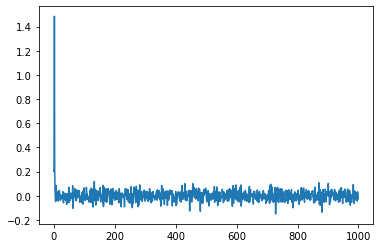

In [15]:
plt.plot(output)